### This lab is based on [the original PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)

#### The goal of this notebook is to learn how to train a Convolutional Neural Networks model to classify images from the CIFAR10 dataset. 

In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

For vision data, there is a package in PyTorch called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this lab, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![](cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data

1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from imagenet10 import ImageNet10
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import pandas as pd
import os
from config import *


# Gathers the meta data for the images
paths, classes = [], []
for i, dir_ in enumerate(CLASS_LABELS):
    for entry in os.scandir(ROOT_DIR + dir_):
        if (entry.is_file()):
            paths.append(entry.path)
            classes.append(i)
            
data = {
    'path': paths,
    'class': classes
}


data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

# See what the dataframe now contains
print("Found", len(data_df), "images.")
# If you want to see the image meta data
print(data_df.head())

# Split the data into train and test sets and instantiate our new ImageNet10 objects.
train_split = 0.80 # Defines the ratio of train/valid data.

# valid_size = 1.0 - train_size
train_size = int(len(data_df)*train_split)

data_transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD),
    ])

dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

dataset_valid = ImageNet10(
    df=data_df[train_size:].reset_index(drop=True),
    transform=data_transform,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=10,  # The number of samples in a batch
    shuffle=True,
    num_workers=0 
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=10,
    shuffle=True,
    num_workers=0
)

# See what you've loaded
print("len(dataset_train)", len(dataset_train))
print("len(dataset_valid)", len(dataset_valid))

print("len(train_loader)", len(train_loader))
print("len(valid_loader)", len(valid_loader))



Found 8998 images.
                                                path  class
0  imagenet10/train_set/football\n04254680_9042.JPEG      7
1       imagenet10/train_set/mug\n03797390_4264.JPEG      8
2       imagenet10/train_set/cat\n02123159_3683.JPEG      3
3       imagenet10/train_set/mug\n03797390_4229.JPEG      8
4     imagenet10/train_set/canoe\n02951358_3046.JPEG      2
len(dataset_train) 7198
len(dataset_valid) 1800
len(train_loader) 720
len(valid_loader) 180


Let us show some of the training images, for fun.



2. Define a Convolutional Neural Network Model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes = 10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding = 2) 
        self.conv2 = nn.Conv2d(32, 64, 5, padding = 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding = 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [4]:
import torch.optim as optim

# Note: CrossEntropyLoss combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# x -> softmax -> log -> negative log likelihood loss
criterion = nn.CrossEntropyLoss()

# the optimization method:  stochastic gradient descent (optionally with momentum=0.9).
# the learning rate=0.001
optimizer = optim.Adam(net.parameters(), lr=0.001) #momentum=0.9 for SGD

4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [5]:
# this to plot the losses later
losses = {'loss':[], 'val_loss':[]}
num_batches = len(train_loader)
num_batches_val = len(valid_loader)

# number of epochs
n_epoch = 20


for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    epoch_val_loss = 0.0
    
    # loop over the train set in mini-batches
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
    losses['loss'].append(epoch_loss/num_batches)
    print('training loss: ', epoch_loss/num_batches)
    
    # Here we do validation so we don't need to compute the gradient
    with torch.no_grad():
        # loop over the validation set
        for val_data in valid_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = net(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            epoch_val_loss += val_loss.item()
    print('validation loss: ',epoch_val_loss/num_batches_val)
    losses['val_loss'].append(epoch_val_loss/num_batches_val)
            
                

print('Finished Training')

training loss:  1.948954711192184
validation loss:  1.8353082531028324
training loss:  1.7077227807707256
validation loss:  1.6538427035013834
training loss:  1.4729330158068075
validation loss:  1.5400998834106656
training loss:  1.166964453127649
validation loss:  1.5525844959749115
training loss:  0.8277906086683894
validation loss:  1.8441149638758765
training loss:  0.5465968557963303
validation loss:  2.3170686728424497
training loss:  0.38148067056835216
validation loss:  2.927658274769783
training loss:  0.2755377194524044
validation loss:  2.964496294657389
training loss:  0.20037972079864833
validation loss:  3.2568038153979515
training loss:  0.17201988951208275
validation loss:  3.4168099992805057
training loss:  0.15672454437535635
validation loss:  3.369105670187208
training loss:  0.14903101640627736
validation loss:  3.788774667514695
training loss:  0.1256429544476911
validation loss:  3.9125980771250193
training loss:  0.11339954387125949
validation loss:  4.421411793

In [6]:
### this function is to plot the losses per epoch
def plot_train_performance(loss, val_loss): 
    epochs       = range(len(loss))
    f1 = plt.figure(1)
    plt.subplot()
    plt.axis((0,len(epochs),0,5))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='valid loss')
    plt.title('Training and valid loss')
    plt.legend()
    plt.show()

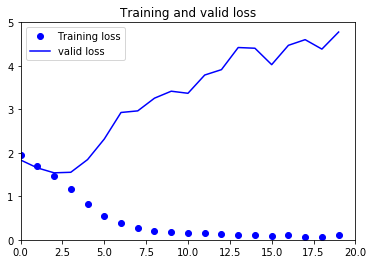

In [7]:
# plotting the losses
plot_train_performance(losses['loss'], losses['val_loss'])

Let's quickly save our trained model:



In [50]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

The results seem pretty good.

Let us look at how the network performs on the whole validation set.



In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 55 %
Accuracy of     1 : 60 %
Accuracy of     2 : 46 %
Accuracy of     3 : 25 %
Accuracy of     4 : 25 %
Accuracy of     5 : 44 %
Accuracy of     6 : 44 %
Accuracy of     7 : 28 %
Accuracy of     8 : 34 %
Accuracy of     9 : 70 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [154]:
net.to(device)
from torch.autograd import Variable
x = torch.randn(1,3,32,32)
x = x.to(device)

net(x)

tensor([[-0.1727,  1.3039, -0.3911, -0.2046, -0.3010, -0.1949,  2.2849,  0.4018,
         -2.2171,  2.2449]], device='cuda:0', grad_fn=<AddmmBackward>)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:


    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

    inputs, labels = data[0].to(device), data[1].to(device)

## Exercise

####  Design an architecture that achieves a loss on the training data (training loss) that is as far below 0.35 as you can.

### You need to modify the current architecture. We propose some possible modifications you should test yourself, in order to select the architecture that you consider best:

- In Conv2D layers: change the dimension of the kernel, the number of kernels, the stride and the padding
- In linear layers: change the number of neurons in the layer.
- Change the number of conv2D and linear layers.
- Change the hyperparameters: learning rate, batch_size,etc.
- change the optimization method